## Imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quad
from data_generation.variables import *

import pickle

import warnings

warnings.filterwarnings('ignore')

In [15]:
h5pydir = 'h5py_dat/'
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Resonance vs delta Rate comparison

In [16]:
import csv

In [27]:
T, rate = [], []
with open('interps/resonant_rate.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        T.append(float(row[0]))
        rate.append(float(row[1]))

In [28]:
rate_interp = UnivariateSpline(T, rate, s=0, k=1)

In [29]:
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))    

def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)


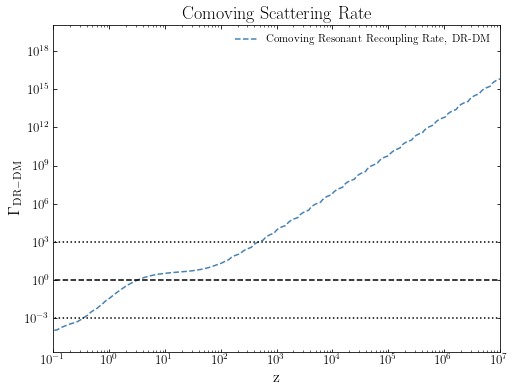

In [30]:
A_recs = [1e16, 1e18]

z_data = np.geomspace(1e-3,1e8,int(1e5))

# plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-2], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-2])))
# plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-1], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-1])))

plt.loglog(z_data, (rate_interp((1+z_data)*0.3*2.73)/((1+z_data)*0.3*2.73)), '--', label='Comoving Resonant Recoupling Rate, DR-DM')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(1e-1,1e7)
# plt.ylim(1e-3,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [33]:
scientific_format(max(z_data))

'$1.0 \\times 10^{8}$'

In [35]:
h5pydir = 'h5py_dat/'
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    z_data = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
    thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)
    a_data = 1/(1+z_data)
    a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
    aprime = a.derivative()

    rho_idr_data = np.array(f["background"]["(.)rho_idr"])
    rho_idm_data = np.array(f["background"]["(.)rho_idm_dr"])
    bkg_tau_data = np.array(f["background"]["conf. time [Mpc]"])
    rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
    rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)


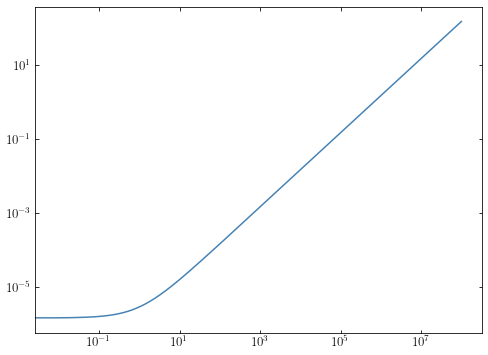

In [36]:
plt.loglog(z_data, rho_idr(thermo_taus(z_data))/rho_idm(thermo_taus(z_data)), label='rho_idr/rho_idm')

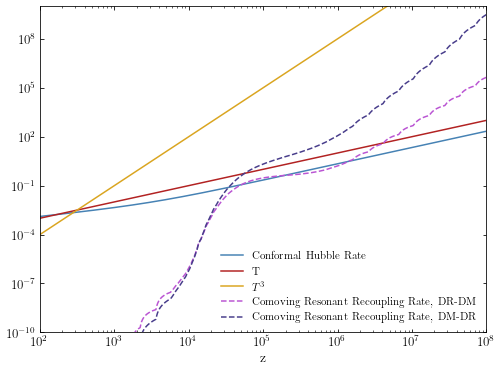

In [79]:
T_dr = (1+z_data)*0.3*2.73
T_dr_ev = T_dr * ktoev

plt.loglog(z_data, aprime(thermo_taus(z_data))/a(thermo_taus(z_data)), label='Conformal Hubble Rate')
plt.loglog(z_data, 1e-5*z_data, label='T')
plt.loglog(z_data, 1e-10*z_data**3, label='$T^3$')
plt.loglog(z_data, 1e-1*rate_interp(T_dr_ev)/T_dr_ev, '--', label='Comoving Resonant Recoupling Rate, DR-DM')
plt.loglog(z_data, 1e-1*rate_interp(T_dr_ev), '--', label='Comoving Resonant Recoupling Rate, DM-DR')

plt.xlim(1e2, 1e8)
plt.ylim(1e-10, 1e10)
plt.xlabel('z')

plt.legend()
plt.show()


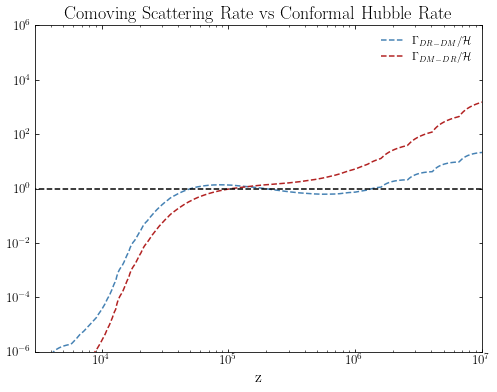

In [65]:
plt.loglog(z_data, 1e-1*(rate_interp(T_dr_ev)/(T_dr_ev))/(aprime(thermo_taus(z_data))/a(thermo_taus(z_data))), '--', label='$\Gamma_{DR-DM} / \mathcal{H}$')
plt.loglog(z_data, 1e-2*(rate_interp(T_dr_ev))/(aprime(thermo_taus(z_data))/a(thermo_taus(z_data))), '--', label='$\Gamma_{DM-DR} / \mathcal{H}$')

# plt.loglog(z_data, 3e-6*(rate_interp((1+z_data)*0.3*2.73))/(aprime(thermo_taus(z_data))/a(thermo_taus(z_data))), '--', label='Gamma DM-DR / conformal Hubble')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.xlim(3e3,1e7)
plt.ylim(1e-6,1e6)
plt.title('Comoving Scattering Rate vs Conformal Hubble Rate')
plt.xlabel('z', fontsize=16)
# plt.ylabel('$\Gamma_{\mathrm{DR-DM}}/H$', fontsize=16)
plt.legend()
plt.show()


## Read in h5py files

In [17]:
#Get data for case with no recoupling
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])

In [18]:
# H_interp = pickle.load(open('interps/H_interp.p','rb')) #H(z)

# H_interp = UnivariateSpline(cos.get_background()['conf. time [Mpc]'], cos.get_background()['H [1/Mpc]'], **spline_pars) #H(Tau)

In [19]:
#Get data for cases with recoupling
delta_chi_dot_arr = []
phi_dot_arr = []
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
theta_dr_arr = []
rho_idr_arr = []
rho_idm_arr = []
theta_chi_dot_arr = []
theta_chi_arr = []
for A_rec in A_recs:
    data_file=h5pydir+'class_model_data_saturation' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))
        thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
        cx2_data = np.flip(np.array(f['thermodynamics']['c_idm_dr^2']))

        theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
        theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])

        psi_data = np.array(f['scalar']['k='+str(k)]['psi'])

        rho_idr_data = np.array(f['background']['(.)rho_idr'])
        rho_idm_data = np.array(f['background']['(.)rho_idm_dr'])
        bkg_tau_data = np.array(f['background']['conf. time [Mpc]'])

        rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
        rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        delta_chi_ddot = delta_chi_dot.derivative()

        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()
        phi_ddot = phi_dot.derivative()

        theta_chi = UnivariateSpline(tau_data, theta_data, **spline_pars)
        theta_chi_dot = theta_chi.derivative()
        theta_dr = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

        psi = UnivariateSpline(tau_data, psi_data, **spline_pars)
        cx2_chi = UnivariateSpline(thermo_tau_data, cx2_data, **spline_pars)

        kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
        kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
        thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)

        a_data = 1/(1+z_data)
        a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
        aprime = a.derivative()

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        delta_chi_dot_arr.append(delta_chi_dot)
        Pk_arr.append(Pks)
        kappa_dot_taus_arr.append(kappa_dot_taus)
        kappa_dot_zs_arr.append(kappa_dot_zs)
        z_arr.append(z_data)
        tau_arr.append(tau_data)
        phi_dot_arr.append(phi_dot)
        thermo_tau_arr.append(thermo_taus)
        theta_dr_arr.append(theta_dr)
        rho_idr_arr.append(rho_idr)
        rho_idm_arr.append(rho_idm)
        theta_chi_arr.append(theta_chi)
        theta_chi_dot_arr.append(theta_chi_dot)

In [20]:
tau_tests = np.geomspace(tau_data[0],tau_data[-1], int(1e4))

In [21]:
Rdark_arr = [4/3*rho_idr_arr[i](7e-2)/rho_idm_arr[i](7e-2) for i in range(len(rho_idr_arr))]

## Recoupling rate calculation

In [22]:
def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)

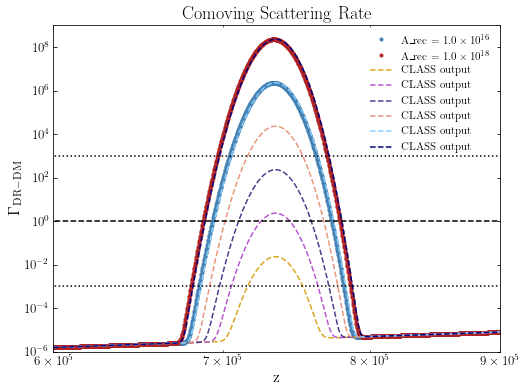

In [27]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-2], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-2])))
plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-1], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-1])))

for i in range(len(A_recs)):
    plt.plot(z_data, kappa_dot_zs_arr[i](z_data), '--',label='CLASS output')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e5,9e5)
plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

## Matter Power Spectrum

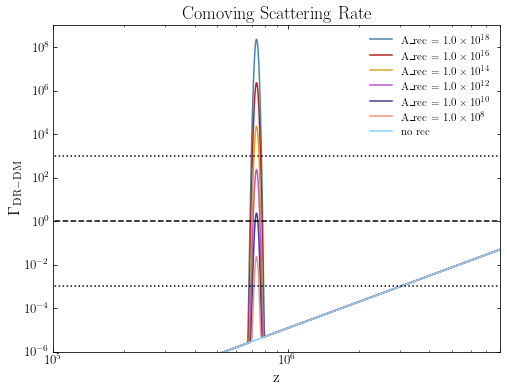

In [31]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_arr[i], kappa_dot_zs_arr[i](z_arr[i]), label='A_rec = ' + scientific_format(A_rec))

plt.plot(z_data_no_rec, kappa_dot_data_no_rec, label='no rec ')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(1e5,8e6)
plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [40]:
Pk_fixed = [Pk_arr[i][390]/Pks_no_rec[390] for i in range(len(A_recs))]

In [41]:
Pk_fixed

[0.9998936476611073,
 0.9904018621513232,
 0.8867217814475248,
 0.08478841308920758,
 0.08081626140902749,
 0.07794350843721372]

In [42]:
np.exp(-1*np.array(np.sqrt(A_recs))*2.5e-9)

array([0.999975  , 0.99975003, 0.99750312, 0.97530991, 0.77880078,
       0.082085  ])

In [43]:
np.exp(-1*np.array(A_recs)*2.5e-18)

array([1.        , 0.99999998, 0.9999975 , 0.99975003, 0.97530991,
       0.082085  ])

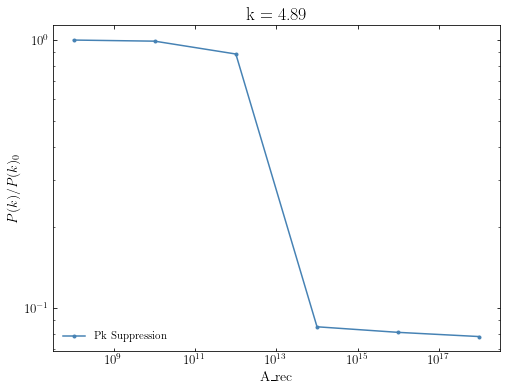

In [44]:
plt.loglog(A_recs,Pk_fixed, '.-', label='Pk Suppression')
# plt.loglog(A_recs,np.exp(-1*np.array(A_recs)*2.5e-18), '.', label = 'exp(-A_rec)')
# plt.loglog(A_recs,np.exp(-1*np.array(np.sqrt(A_recs))*2.5e-9), '.', label = 'exp(-sqrt(A_rec))')

plt.xlabel('A_rec')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('k = {:.2f}'.format(kk[390]))

plt.legend(loc='lower left')


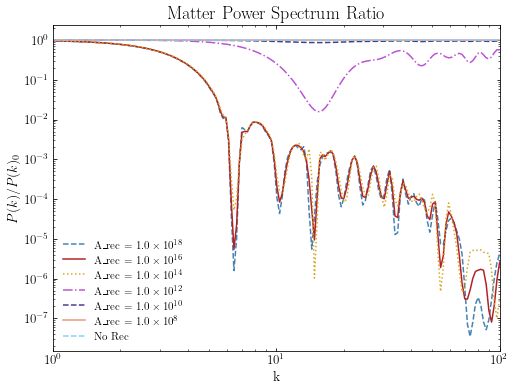

In [45]:
lines = ["-","--","-.",":"]
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(kk, Pk_arr[i]/Pks_no_rec,  ls = lines[i%len(lines)], label='A_rec = ' + scientific_format(A_rec))

plt.plot(kk,Pks_no_rec/Pks_no_rec, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1,1e2)
plt.legend()
plt.show()

## Generate Data (shouldn't need to touch unless re-running CLASS)

In [13]:
from classy import Class

In [14]:
def getPk(classObj):
    kk = np.logspace(-4,np.log10(pk_max),500) # k in h/Mpc
    Pk = [] # P(k) in (Mpc/h)**3
    h = classObj.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk.append(classObj.pk(k*h,z_pk)*h**3) # function .pk(k,z)
    return Pk;

def getPkRatio(classObj1, classObj2):
    #Returns the ratio of the power spectrum of 1 to 2
    return[getPk(classObj1)[i]/getPk(classObj2)[i] for i in range(len(kk))]
    

def getdmu_idm_dr(classObj):
    return classObj.get_thermodynamics()['dmu_idm_dr']
    
def getzs(classObj):
    return classObj.get_thermodynamics()['z']

def getH(classObj):
    zs = np.flip(classObj.get_background()['z'])
    Hs = np.flip(classObj.get_background()['H [1/Mpc]'])
    return UnivariateSpline(zs, Hs, k=1.0, s=0.0)


def getDat(classObj):
    dmu_idm_dr = getdmu_idm_dr(classObj);
    zs = getzs(classObj)
    Hspline = getH(classObj)
    
    return dmu_idm_dr, zs, Hspline

# def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, h =0.67556, xi_idr = 0.3 ):
#     base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr * h**2 

#     if T_rec >= (xi_idr * 2.73) * (1+z) and (xi_idr*2.73) * (1+z) > T_rec*0.99:
#         return base_rate*(1+A_rec)
#     else:
#         return base_rate

def save_class_obj(class_obj,A_rec):
    model = class_obj
    data_file=h5pydir+'class_model_data_saturation' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'w') as f:    
        # Scalar group
        data = model.get_perturbations()['scalar']
        sub_group = f.create_group('scalar')
        for i, k in enumerate(BM_KS):
            sub_sub_group = sub_group.create_group(f'k={k}')
            d = data[i]
            for key, val in d.items():
                sub_sub_group.create_dataset(key, data=val)
        
        # Background group
        data = model.get_background()
        sub_group = f.create_group('background')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)
        
        # Thermo group
        data = model.get_thermodynamics()
        sub_group = f.create_group('thermodynamics')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

        # Power Spectrum group
        data = getPk(model)
        sub_group = f.create_group('power_spectrum')
        sub_group.create_dataset('kk', data=kk)
        sub_group.create_dataset('Pk', data=data) 

In [15]:
commonset = {
    'omega_b': 0.022032,
    'omega_cdm': omega0_cdm,
    'h': 0.67556,
    'A_s': 2.215e-9,
    'n_s': 0.9619,
    'tau_reio': 0.0925,
    'output': 'tCl,pCl,lCl,mPk',
    'lensing': 'yes',
    'P_k_max_1/Mpc': pk_max,
    'z_pk': 0.0,
    'k_output_values':'10',
}

idrset = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    'nindex_idm_dr': 4.0, 
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 1.0e0,
    'rec_case': 4, #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling 
}

In [16]:
sigma_fac = 0.01

for A_rec in A_recs:
    cos = Class()
    cos.set(commonset)
    cos.set(idrset)
    cos.set({
        'rec_case': 3,
        'A_rec':A_rec,
        'T_rec':T_rec,
        'sigma' : sigma_fac*T_rec #Gaussian width
        })
    cos.compute() 

    save_class_obj(cos,A_rec)
    
    # clear content of cos (to reuse it for another model)
    cos.struct_cleanup()
    # reset parameters to default
    cos.empty()

In [ ]:
LambdaCDM = Class()
LambdaCDM.set(commonset)
LambdaCDM.compute()
LambdaCDMPk = getPk(LambdaCDM);

In [ ]:
idrNoRec = Class()
idrNoRec.set(commonset)
idrNoRec.set(idrset)

idrNoRec.compute()

In [ ]:
model = idrNoRec
with h5py.File(h5pydir+'class_model_data_no_rec.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 